# def final_fun_1(X):

In [1]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sns
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("Solarize_Light2")
%matplotlib inline

In [2]:
def final_fun_1(PdM_telemetry, PdM_errors, PdM_maint, PdM_machines, finalized_model):
    '''
    This function returns status of failure of machines' components with the following inputs:
    
    PdM_telemetry = Hourly average data of voltage, rotation, pressure, vibration 
                    collected from machines. 
   
    PdM_errors = Errors encountered by the machines in operating condition.
    PdM_maint = Replacement of component history.
    PdM_machines = Model type & age of the Machines (Metadata of machine).
    finalized_model = A pre-trained Machine Learning model. 
    
    '''

    #Loading all the datasets using Pandas library
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')

    telemetry = pd.read_csv(PdM_telemetry, nrows= 66666)
    errors = pd.read_csv(PdM_errors)
    maint = pd.read_csv(PdM_maint)
    machines = pd.read_csv(PdM_machines)

    # Formating datetime field.
    telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
    errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
    errors['errorID'] = errors['errorID'].astype('category')
    maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
    maint['comp'] = maint['comp'].astype('category')
    machines['model'] = machines['model'].astype('category')

    #Lag Features from Telemetry data
    # Calculate "resample min values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                   index='datetime',
                                   columns='machineID',
                            values=col).resample('3H', closed='left', label='right').min().unstack())

    telemetry_min_3h = pd.concat(temp, axis=1)
    telemetry_min_3h.columns = [i + '_min_3h' for i in fields]
    telemetry_min_3h.reset_index(inplace=True)

    # Calculate "resample max values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                   index='datetime',
                                   columns='machineID',
                            values=col).resample('3H', closed='left', label='right').max().unstack())

    telemetry_max_3h = pd.concat(temp, axis=1)
    telemetry_max_3h.columns = [i + '_max_3h' for i in fields]
    telemetry_max_3h.reset_index(inplace=True)

    # Calculate "resample mean values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                   index='datetime',
                                   columns='machineID',
                            values=col).resample('3H', closed='left', label='right').mean().unstack())

    telemetry_mean_3h = pd.concat(temp, axis=1)
    telemetry_mean_3h.columns = [i + '_mean_3h' for i in fields]
    telemetry_mean_3h.reset_index(inplace=True)

    # Calculate "resample standard deviation" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                   index='datetime',
                                   columns='machineID',
                            values=col).resample('3H', closed='left', label='right').std().unstack())

    telemetry_sd_3h = pd.concat(temp, axis=1)
    telemetry_sd_3h.columns = [i + '_sd_3h' for i in fields]
    telemetry_sd_3h.reset_index(inplace=True)

    #Capturing a longer term effect, 24 hour lag features

    #Calculate "rolling min" over the last 24 hour lag window for telemetry features.

    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                   columns='machineID',
                                        values=col).rolling(window=24,center=False).min().resample('3H',
                                                                        closed='left', 
                                                                    label='right').first().unstack())                                                                                


    telemetry_min_24h = pd.concat(temp, axis=1)       
    telemetry_min_24h.columns = [i + '_min_24h' for i in fields]
    telemetry_min_24h.reset_index(inplace=True)
    telemetry_min_24h = telemetry_min_24h.loc[-telemetry_min_24h['volt_min_24h'].isnull()]

    #Calculate "rolling max" over the last 24 hour lag window for telemetry features.

    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                   columns='machineID',
                                    values=col).rolling(window=24,center=False).max().resample('3H', 
                                                                                        closed='left', 
                                                                        label='right').first().unstack())                                                                                


    telemetry_max_24h = pd.concat(temp, axis=1)       
    telemetry_max_24h.columns = [i + '_max_24h' for i in fields]
    telemetry_max_24h.reset_index(inplace=True)
    telemetry_max_24h = telemetry_max_24h.loc[-telemetry_max_24h['volt_max_24h'].isnull()]

    #Calculate "rolling mean" over the last 24 hour lag window for telemetry features.

    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                   columns='machineID',
                                        values=col).rolling(window=24,center=False).mean().resample('3H',
                                                                                    closed='left', 
                                                                label='right').first().unstack())                                                                                


    telemetry_mean_24h = pd.concat(temp, axis=1)       
    telemetry_mean_24h.columns = [i + '_mean_24h' for i in fields]
    telemetry_mean_24h.reset_index(inplace=True)
    telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['volt_mean_24h'].isnull()]

    #Calculate "rolling standard deviation" over the last 24 hour lag window for telemetry features.

    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                   columns='machineID',
                                values=col).rolling(window=24,center=False).std().resample('3H', 
                                                    closed='left', label='right').first().unstack())   

    telemetry_sd_24h = pd.concat(temp, axis=1)
    telemetry_sd_24h.columns = [i + '_sd_24h' for i in fields]
    telemetry_sd_24h.reset_index(inplace=True)
    telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['volt_sd_24h'].isnull()]

    # Merge columns of feature sets created earlier
    telemetry_feat = pd.concat([telemetry_min_3h,
                                telemetry_max_3h.iloc[:, 2:6],
                                telemetry_mean_3h.iloc[:, 2:6],
                                telemetry_sd_3h.iloc[:, 2:6],
                                telemetry_min_24h.iloc[:, 2:6],
                                telemetry_max_24h.iloc[:, 2:6],
                                telemetry_mean_24h.iloc[:, 2:6],
                                telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()


    #Lag Features from Errors dataset
    # Create a column for each error type
    error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
    error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
    # Combine errors for a given machine in a given hour
    error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
    error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], 
                                                             how='left').fillna(0.0)

    #Total number of errors of each type over the last 24 hours
    temp = []
    fields = ['error%d' % i for i in range(1,6)]
    for col in fields:
        temp.append(pd.pivot_table(error_count,
                                                   index='datetime',
                                                   columns='machineID',
                                             values=col).rolling(window=24).sum().resample('3H', 
                                                        closed='left', label='right').first().unstack())


    error_count = pd.concat(temp, axis=1)
    error_count.columns = [i + 'count' for i in fields]
    # error_count.reset_index(inplace=True)#To be activate
    error_count = error_count.dropna()

    # Days Since Last Replacement from Maintenance
    import numpy as np

    # Create a column for each error type
    comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
    comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

    # Combine repairs for a given machine in a given hour
    comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

    # Add timepoints where no components were replaced
    comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                        on=['datetime', 'machineID'],
                                         how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])


    components = ['comp1', 'comp2', 'comp3', 'comp4']
    for comp in components:
        # Convert indicator to most recent date of component change
        comp_rep.loc[comp_rep[comp] < 1, comp] = None
        comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(),'datetime']

        # Forward-fill the most-recent date of component change
        comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

    # Remove dates in 2014 (may have NaN or future component change dates)    
    comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

    # Replace dates of most recent component change with days since most recent component change
    for comp in components:
        comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')


    #Machine Features
    final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
    final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
    final_feat = final_feat.merge(machines, on=['machineID'], how='left')

    #Preparation for prediction
    X = final_feat.drop(['datetime', 'machineID'], 1)
    X_final = pd.get_dummies(X)
    X_final_train = X_final.values

    import pickle 
    # load the model from disk
    model = pickle.load(open(finalized_model, 'rb'))
    prediction = model.predict(X_final_train)
    
    return prediction

In [3]:
%%time
#Testing def final_fun_1
PdM_telemetry = 'PdM_telemetry.csv'
PdM_errors = 'PdM_errors.csv'
PdM_maint = 'PdM_maint.csv'
PdM_machines = 'PdM_machines.csv'
finalized_model = 'finalized_model.sav'
final_fun_1(PdM_telemetry, PdM_errors, PdM_maint, PdM_machines, finalized_model)

Wall time: 8.29 s


array(['none', 'none', 'none', ..., 'none', 'none', 'none'], dtype='<U5')

In [7]:
#time/nos of data points (UoM = sec/data point)
8.29/66666

0.0001243512435124351

<b> Average time for execution of "def final_fun_1" = 66666/8.29 =0.12435 milliseconds/data point

# def final_fun_2(X,Y):

In [4]:
def final_fun_2(PdM_telemetry, PdM_errors, PdM_maint, PdM_machines, finalized_model,Label_final):
    '''
    This function returns status of failure of machines' components with the following inputs:
    
    PdM_telemetry = Hourly average data of voltage, rotation, pressure, vibration 
                    collected from machines. 
   
    PdM_errors = Errors encountered by the machines in operating condition.
    PdM_maint = Replacement of component history.
    PdM_machines = Model type & age of the Machines (Metadata of machine).
    finalized_model = A pre-trained Machine Learning model. 
    
    '''

    #Loading all the datasets using Pandas library
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')

    telemetry = pd.read_csv(PdM_telemetry, nrows= 66666)
    errors = pd.read_csv(PdM_errors)
    maint = pd.read_csv(PdM_maint)
    machines = pd.read_csv(PdM_machines)

    # Formating datetime field.
    telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
    errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
    errors['errorID'] = errors['errorID'].astype('category')
    maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
    maint['comp'] = maint['comp'].astype('category')
    machines['model'] = machines['model'].astype('category')

    #Lag Features from Telemetry data
    # Calculate "resample min values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                   index='datetime',
                                   columns='machineID',
                            values=col).resample('3H', closed='left', label='right').min().unstack())

    telemetry_min_3h = pd.concat(temp, axis=1)
    telemetry_min_3h.columns = [i + '_min_3h' for i in fields]
    telemetry_min_3h.reset_index(inplace=True)

    # Calculate "resample max values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                   index='datetime',
                                   columns='machineID',
                            values=col).resample('3H', closed='left', label='right').max().unstack())

    telemetry_max_3h = pd.concat(temp, axis=1)
    telemetry_max_3h.columns = [i + '_max_3h' for i in fields]
    telemetry_max_3h.reset_index(inplace=True)

    # Calculate "resample mean values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                   index='datetime',
                                   columns='machineID',
                            values=col).resample('3H', closed='left', label='right').mean().unstack())

    telemetry_mean_3h = pd.concat(temp, axis=1)
    telemetry_mean_3h.columns = [i + '_mean_3h' for i in fields]
    telemetry_mean_3h.reset_index(inplace=True)

    # Calculate "resample standard deviation" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                   index='datetime',
                                   columns='machineID',
                            values=col).resample('3H', closed='left', label='right').std().unstack())

    telemetry_sd_3h = pd.concat(temp, axis=1)
    telemetry_sd_3h.columns = [i + '_sd_3h' for i in fields]
    telemetry_sd_3h.reset_index(inplace=True)

    #Capturing a longer term effect, 24 hour lag features

    #Calculate "rolling min" over the last 24 hour lag window for telemetry features.

    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                   columns='machineID',
                                        values=col).rolling(window=24,center=False).min().resample('3H',
                                                                        closed='left', 
                                                                    label='right').first().unstack())                                                                                


    telemetry_min_24h = pd.concat(temp, axis=1)       
    telemetry_min_24h.columns = [i + '_min_24h' for i in fields]
    telemetry_min_24h.reset_index(inplace=True)
    telemetry_min_24h = telemetry_min_24h.loc[-telemetry_min_24h['volt_min_24h'].isnull()]

    #Calculate "rolling max" over the last 24 hour lag window for telemetry features.

    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                   columns='machineID',
                                    values=col).rolling(window=24,center=False).max().resample('3H', 
                                                                                        closed='left', 
                                                                        label='right').first().unstack())                                                                                


    telemetry_max_24h = pd.concat(temp, axis=1)       
    telemetry_max_24h.columns = [i + '_max_24h' for i in fields]
    telemetry_max_24h.reset_index(inplace=True)
    telemetry_max_24h = telemetry_max_24h.loc[-telemetry_max_24h['volt_max_24h'].isnull()]

    #Calculate "rolling mean" over the last 24 hour lag window for telemetry features.

    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                   columns='machineID',
                                        values=col).rolling(window=24,center=False).mean().resample('3H',
                                                                                    closed='left', 
                                                                label='right').first().unstack())                                                                                


    telemetry_mean_24h = pd.concat(temp, axis=1)       
    telemetry_mean_24h.columns = [i + '_mean_24h' for i in fields]
    telemetry_mean_24h.reset_index(inplace=True)
    telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['volt_mean_24h'].isnull()]

    #Calculate "rolling standard deviation" over the last 24 hour lag window for telemetry features.

    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                   columns='machineID',
                                values=col).rolling(window=24,center=False).std().resample('3H', 
                                                    closed='left', label='right').first().unstack())   

    telemetry_sd_24h = pd.concat(temp, axis=1)
    telemetry_sd_24h.columns = [i + '_sd_24h' for i in fields]
    telemetry_sd_24h.reset_index(inplace=True)
    telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['volt_sd_24h'].isnull()]

    # Merge columns of feature sets created earlier
    telemetry_feat = pd.concat([telemetry_min_3h,
                                telemetry_max_3h.iloc[:, 2:6],
                                telemetry_mean_3h.iloc[:, 2:6],
                                telemetry_sd_3h.iloc[:, 2:6],
                                telemetry_min_24h.iloc[:, 2:6],
                                telemetry_max_24h.iloc[:, 2:6],
                                telemetry_mean_24h.iloc[:, 2:6],
                                telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()


    #Lag Features from Errors dataset
    # Create a column for each error type
    error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
    error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
    # Combine errors for a given machine in a given hour
    error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
    error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], 
                                                             how='left').fillna(0.0)

    #Total number of errors of each type over the last 24 hours
    temp = []
    fields = ['error%d' % i for i in range(1,6)]
    for col in fields:
        temp.append(pd.pivot_table(error_count,
                                                   index='datetime',
                                                   columns='machineID',
                                             values=col).rolling(window=24).sum().resample('3H', 
                                                        closed='left', label='right').first().unstack())


    error_count = pd.concat(temp, axis=1)
    error_count.columns = [i + 'count' for i in fields]
    # error_count.reset_index(inplace=True)#To be activate
    error_count = error_count.dropna()

    # Days Since Last Replacement from Maintenance
    import numpy as np

    # Create a column for each error type
    comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
    comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

    # Combine repairs for a given machine in a given hour
    comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

    # Add timepoints where no components were replaced
    comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                        on=['datetime', 'machineID'],
                                         how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])


    components = ['comp1', 'comp2', 'comp3', 'comp4']
    for comp in components:
        # Convert indicator to most recent date of component change
        comp_rep.loc[comp_rep[comp] < 1, comp] = None
        comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(),'datetime']

        # Forward-fill the most-recent date of component change
        comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

    # Remove dates in 2014 (may have NaN or future component change dates)    
    comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

    # Replace dates of most recent component change with days since most recent component change
    for comp in components:
        comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')


    #Machine Features
    final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
    final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
    final_feat = final_feat.merge(machines, on=['machineID'], how='left')

    #Preparation for prediction
    X = final_feat.drop(['datetime', 'machineID'], 1)
    X_final = pd.get_dummies(X)
    X_final_train = X_final.values

    import pickle 
    # load the model from disk
    model = pickle.load(open(finalized_model, 'rb'))
    prediction = model.predict(X_final_train)
    
    y_final_train= pd.read_csv(Label_final).values
    
    from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
    import seaborn as sns
    def plot_confusion_matrix(test_y, predict_y):
        C = confusion_matrix(test_y, predict_y)
        A =(((C.T)/(C.sum(axis=1))).T)
        B =(C/C.sum(axis=0))

        labels = ['comp1', 'comp2', 'comp3', 'comp4', 'none']
        # representing A in heatmap format
        print("-"*20, "Confusion matrix", "-"*20)
        plt.figure(figsize=(20,7))
        sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.show()

        print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
        plt.figure(figsize=(20,7))
        sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.show()

        # representing B in heatmap format
        print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
        plt.figure(figsize=(20,7))
        sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.show()
    
    
    return plot_confusion_matrix(y_final_train, model.predict(X_final_train))

-------------------- Confusion matrix --------------------


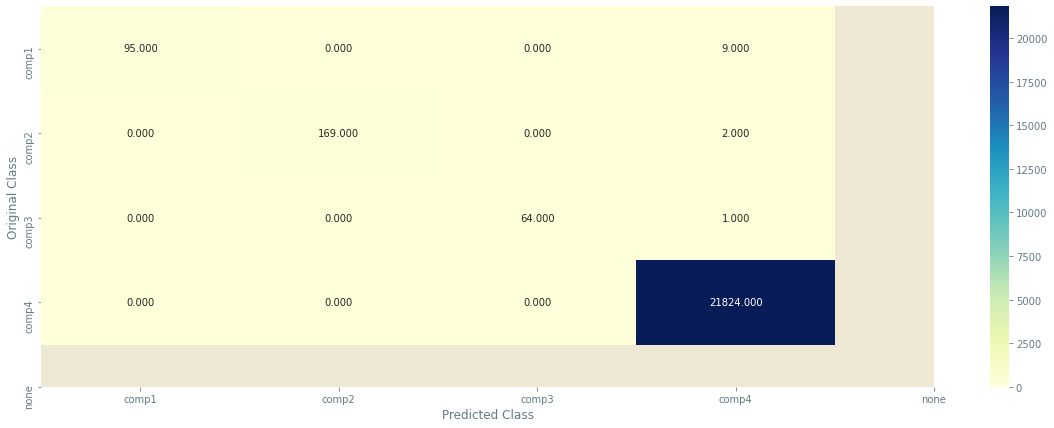

-------------------- Precision matrix (Columm Sum=1) --------------------


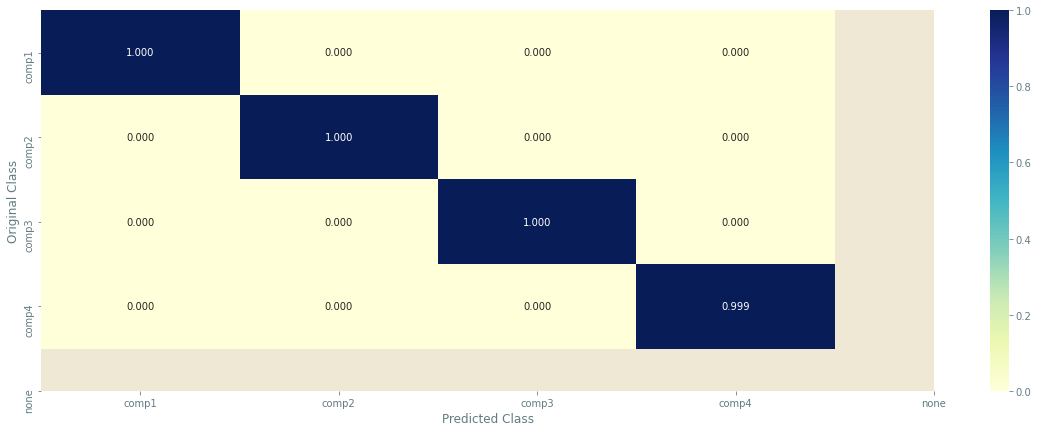

-------------------- Recall matrix (Row sum=1) --------------------


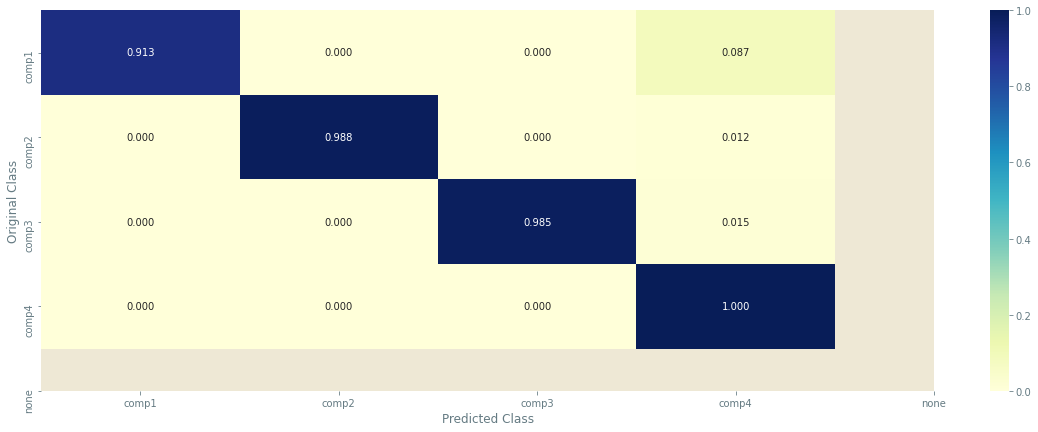

Wall time: 9.62 s


In [5]:
%%time
#Testing def final_fun_2
PdM_telemetry = 'PdM_telemetry.csv'
PdM_errors = 'PdM_errors.csv'
PdM_maint = 'PdM_maint.csv'
PdM_machines = 'PdM_machines.csv'
finalized_model = 'finalized_model.sav'
Label_final = 'Label_final.csv'
final_fun_2(PdM_telemetry, PdM_errors, PdM_maint, PdM_machines, finalized_model, Label_final)

In [8]:
#time/nos of data points (UoM = sec/data point)
9.62/66666

0.00014430144301443013

<b> Average time for execution of "def final_fun_2" = 66666/9.62 =0.1443 milliseconds/data point

# Summary of Case study-1:

<b>Summary:</b> 

There are 5 numbers of datasets (CSV files) downloaded from Kaggle to perform this Case Study. The data comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In this Case study, the steps of implementing a predictive maintenance model is provided using an example scenario where the goal is to predict failures due to certain components of a machine within 24-hour. Typical steps of predictive maintenance such as Exploratory data analysis (EDA), Feature Engineering, Labelling, Training and Evaluation are explained using the datasets. 

During EDA step, it helps us to find out valuable insight of the datasets which can be used by Maintenance Executives to perform any Data Driven Approach such as "Root cause analysis" of any unwanted situation. For instance, during EDA step, we can detect the ID (tag number) of Machine which have highest number of errors leading to failure. 

During EDA step, it is observed that datasets are having time-stamps. Accordingly, we have created new features relevant to time series analysis for our predictive model.

In this study, we have trained lots of Machine Learning Model (eg. Logistic Regression, Support Vector Classification, LinearSVC, Extra Trees Classifier, Bagging Classifier, Random Forest, XgBoost etc.) and compared their performance metrics under "Model Building Section". After doing the hyper-meter tuning of the Machine Learning Models, it is found that <b>"XgBoost Model"</b> performed better on the performance metric as compared to the other models for prediction of component failure in advance (next 24 hours). 

In the below section, it is also listed the major advantage, limitation of list of various challenges during adaption of AI/ML in Predictive Maintenance in companies and future improvement/study of this case study:

<b> (a) List of significant advantages of adapting AI/ML in Predictive Maintenance (PdM) in companies:</b>
- <b>(i)  Improving operating equipment’s reliability and reducing maintenance expenses:</b> 
   AI/ML solutions provide smart tools that are used for estimating the potential breakdowns before occurring. This feature allows companies to prepare an effective plan for maintenance work and prioritize their focus on critical equipment, based on a high possibility of failure. As a result, companies can reduce maintenance expenses where unnecessary work can be eliminated by prioritizing planned maintenance based on a failure forecast. 

- <b> (ii) Improving efficiency of operating equipment: </b> 
AI/ML solutions maximize the utilization of operating equipment and enhance the operating unit productivity through ensuring more reliable and flexible operation. Data modelling gives a deep indication for several parts of operating equipment, which helps companies in maintaining the production performance and establishes a mechanism in improving the operating equipment lifespan. 

- <b> (iii) Reducing environmental impact: </b>
AI/ML solutions can reduce the environmental impact associated with leak detection including oil and gas companies. Adapting such solutions help companies to detect the potential leaks in petrochemical pipelines before occurring.

- <b> (iv) Leverage past and continuous data:</b>
Past and continuous data of machines help to build robust AI/ML solutions in Predictive Analysis.

<b>(b) List of various challenges and limitations during adaption of AI/ML in Predictive
Maintenance in companies:</b>

- If predictive maintenance is so great, why isn’t everyone doing it? Well, for one, there needs to be a relevant and feasible use case. Predictive maintenance is also much harder than either of the two other simpler maintenance strategies followed by every companies. Many of these difficulties can be traced back to the data to work with. A lot of times is consumed in “big data” processing. Big data is usually characterized by various “v’s”, including volume, variety, velocity, veracity, and value. <br>

<b>Volume: </b>

 Each piece of equipment might have dozens of sensors, each of which is constantly monitoring the machine over its lifetime. A single Boeing jet, for instance, generates as much as 10 terabytes of data during 30 minutes of flight time. Effectively processing and analyzing the sheer amount of data can quickly become a daunting task. 
 
<b>Variety:</b>

 Sensors might be recording data in different formats or at different time scales. This is just for one piece of equipment. It is quite common task to deal with different models or different types of machines in a larger plant. 
 
<b>Velocity:</b>

 Data may be generated quickly, leading to problems of how it can be extracted signals or aggregate these readings over time and analyze this data in real time. 

<b>Veracity:</b>

 Data can often be of dubious quality, and some data may be missing. Sensor data is often noisy, and sensors themselves can easily become defective. 
 
<b>Value:</b>

 There may (or may not!) be useful information in the data that can be extracted to help inform decision making. This is what AI/ML Engineers want to uncover!
Beyond these big data challenges, there might be some additional challenges. AI/ML Engineers may be dealing with data of high dimensionality with complex correlations between variables. Reasoning in these high dimensional spaces is difficult and uncovering these correlations can be next to impossible for a human. This is where machine learning can help. 


<b> (c) Future improvement/study: </b>
- The final Xgboost model can predict the failure due to comp1 and comp4 around 97% correctly. So by exploring additional features, prediction of failure of this model may be improved. 

- The final Xgboost model can predict the failure due to certain components of a machine within 24-hour only.
However prediction of this model may be validated and improved for more than 24-hour (say 48 hrs, 96 hrs etc.).

# >>>> End of notebook <<<<<